--------
# Cuaderno 02: Entrenamiento de Clasificadores Expertos para Pérdida Perceptual

### El "Porqué" Cognitivo: Creando un Ground-Truth Neuronal 🧠

El objetivo de este cuaderno es fundamentalmente crear y validar nuestro **Ground-Truth (verdad fundamental) a nivel neuronal**. En neurociencia cognitiva, se postula que el cerebro desarrolla representaciones neuronales estables y distinguibles para los estímulos que aprende a reconocer. Un fonema como la 'a' o una palabra como 'casa' activan patrones consistentes en el córtex auditivo.

Nuestros **clasificadores expertos** son una emulación de este proceso. Entrenamos modelos para que sean excepcionalmente buenos en una única tarea: identificar un fonema o una palabra a partir de su "imagen auditiva" (la secuencia de embeddings de `wav2vec2`). Si estos modelos logran una alta precisión, podemos confiar en que las representaciones neuronales que han aprendido internamente son un buen análogo de esas representaciones estables en el cerebro. Se convierten en nuestra **medida de lo que es "correcto"**.

### El "Cómo" Técnico: La Pérdida Perceptual y la Elección de Arquitectura

#### ¿Usaremos esto para aplicar la Pérdida Perceptual?

**Sí, exactamente.** Este es el propósito central de este cuaderno. En los cuadernos posteriores (03 y 04), construiremos modelos **generativos** que deben "imaginar" o crear estos embeddings desde cero (a partir de fonemas o grafemas). ¿Cómo saber si lo que "imaginan" es correcto?

Ahí es donde entra la **pérdida perceptual**. En lugar de usar una simple comparación matemática (como el Error Cuadrático Medio), usaremos a nuestros expertos como "jueces". La función de pérdida del modelo generativo se basará en qué tan bien puede "engañar" a nuestro experto para que clasifique su embedding imaginado como la palabra correcta. Si el juez es mediocre, el feedback que le da al generador es inútil. Por eso, dedicamos este cuaderno entero a asegurar que nuestros jueces sean de la más alta calidad.

#### La Arquitectura: ¿Por qué LSTM aquí y no Transformers?

Esta es una distinción crucial en nuestro proyecto:

1.  **Para la Clasificación (Este Cuaderno)**: Usamos un **LSTM Bidireccional**. Un LSTM es un maestro en procesar secuencias **temporales**. Analiza el embedding de audio paso a paso, manteniendo una memoria de lo que ha "escuchado" antes. Al ser bidireccional, lo hace de principio a fin y de fin a principio, capturando la dinámica completa del sonido. Es ideal para una tarea de **análisis y discriminación** de una señal ya existente.

2.  **Para la Generación (Cuadernos Futuros)**: Usaremos **Transformers** como **Encoders**. El Transformer, con su mecanismo de auto-atención, es un experto en entender el **contexto** y las relaciones entre todos los elementos de una secuencia *a la vez*. Es perfecto para tomar una secuencia de fonemas ("c-a-s-a") y crear una representación abstracta y rica de su significado conjunto. Esta representación luego se pasará a un *Decoder* (un LSTM, en nuestro caso) para generar la secuencia de salida.

En resumen: usamos **LSTM para analizar** una señal temporal y **Transformers para codificar el contexto** de una secuencia simbólica.

--------

In [8]:
# ===================================================================
# Celda 2: Configuración e Instalación
# ===================================================================
%pip install torch scikit-learn seaborn pandas matplotlib --quiet

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from pathlib import Path
import numpy as np, pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import glob, warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

Note: you may need to restart the kernel to use updated packages.


In [9]:
# ===================================================================
# Celda 3: Parámetros Globales y Rutas
# ===================================================================
LANGUAGES = ['es', 'en']; MODEL_ARCHITECTURE = "expert_classifier_lstm"
EPOCHS = 200; BATCH_SIZE = 16; LEARNING_RATE = 0.0005
VALIDATION_SPLIT = 0.2; RANDOM_SEED = 42
EMBED_DIM = 1024; LSTM_HIDDEN_DIM = 256; LSTM_N_LAYERS = 2; LSTM_DROPOUT = 0.4
project_root = Path.cwd().parent
dictionaries_dir = project_root/"data/01_raw/dictionaries"
phoneme_embedding_dir_base = project_root/"data/02_processed/wav2vec2_embeddings"
word_embedding_dir_base = project_root/"data/02_processed/word_embeddings"
model_dir = project_root/"results/trained_models"
figure_dir = project_root/"results/figures"
model_dir.mkdir(parents=True, exist_ok=True); figure_dir.mkdir(parents=True, exist_ok=True)
torch.manual_seed(RANDOM_SEED); np.random.seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# ===================================================================
# Celda 4: Definición de Clases Genéricas (Dataset y Modelo)
# ===================================================================
class SequentialEmbeddingDataset(Dataset):
    def __init__(self, embedding_dir):
        self.embedding_files = sorted(glob.glob(str(embedding_dir / '*.npy')))
        self.labels = sorted([Path(f).stem for f in self.embedding_files])
        self.label_to_int = {label: i for i, label in enumerate(self.labels)}
        self.int_to_label = {i: label for label, i in self.label_to_int.items()}
    def __len__(self): return len(self.embedding_files)
    def __getitem__(self, idx):
        file_path = self.embedding_files[idx]
        sequence = torch.tensor(np.load(file_path), dtype=torch.float32)
        label_str = Path(file_path).stem
        label_int = torch.tensor(self.label_to_int[label_str], dtype=torch.long)
        return sequence, label_int

def collate_fn_sequential(batch):
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences])
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)
    return padded_sequences, lengths, torch.stack(labels)

class SequentialClassifierLSTM(nn.Module):
    def __init__(self, embed_dim, num_classes, hidden_dim, n_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout if n_layers > 1 else 0, bidirectional=True)
        self.classifier_head = nn.Linear(hidden_dim * 2, num_classes)
    def forward(self, x_padded, x_lengths):
        packed_input = nn.utils.rnn.pack_padded_sequence(x_padded, x_lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, _) = self.lstm(packed_input)
        hidden_concat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        return self.classifier_head(hidden_concat)

# Parte 1: Entrenamiento del Experto en Fonemas
Entrenaremos un modelo por cada idioma para que aprenda a clasificar los fonemas a partir de sus secuencias de embeddings.

In [11]:
# ===================================================================
# Celda 5: Bucle de Entrenamiento - Experto en Fonemas
# ===================================================================
results_phonemes = {}
for lang in LANGUAGES:
    print(f"--- Entrenando Experto en Fonemas para: {lang.upper()} ---")
    phoneme_embedding_dir = phoneme_embedding_dir_base / lang
    full_dataset = SequentialEmbeddingDataset(phoneme_embedding_dir)
    num_classes = len(full_dataset.labels)
    train_size = int((1.0 - VALIDATION_SPLIT) * len(full_dataset)); val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_sequential)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_sequential)
    model = SequentialClassifierLSTM(EMBED_DIM, num_classes, LSTM_HIDDEN_DIM, LSTM_N_LAYERS, LSTM_DROPOUT).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE); criterion = nn.CrossEntropyLoss()
    for epoch in tqdm(range(EPOCHS), desc=f"Entrenando Fonemas {lang.upper()}", leave=False):
        model.train()
        for seqs, lengths, labels in train_loader:
            seqs, labels = seqs.to(device), labels.to(device)
            optimizer.zero_grad(); outputs = model(seqs, lengths)
            loss = criterion(outputs, labels); loss.backward(); optimizer.step()
    results_phonemes[lang] = {'model': model, 'dataset': full_dataset}

--- Entrenando Experto en Fonemas para: ES ---


Entrenando Fonemas ES:   0%|          | 0/200 [00:00<?, ?it/s]

--- Entrenando Experto en Fonemas para: EN ---


Entrenando Fonemas EN:   0%|          | 0/200 [00:00<?, ?it/s]

--- Evaluando Experto en Fonemas para: ES ---


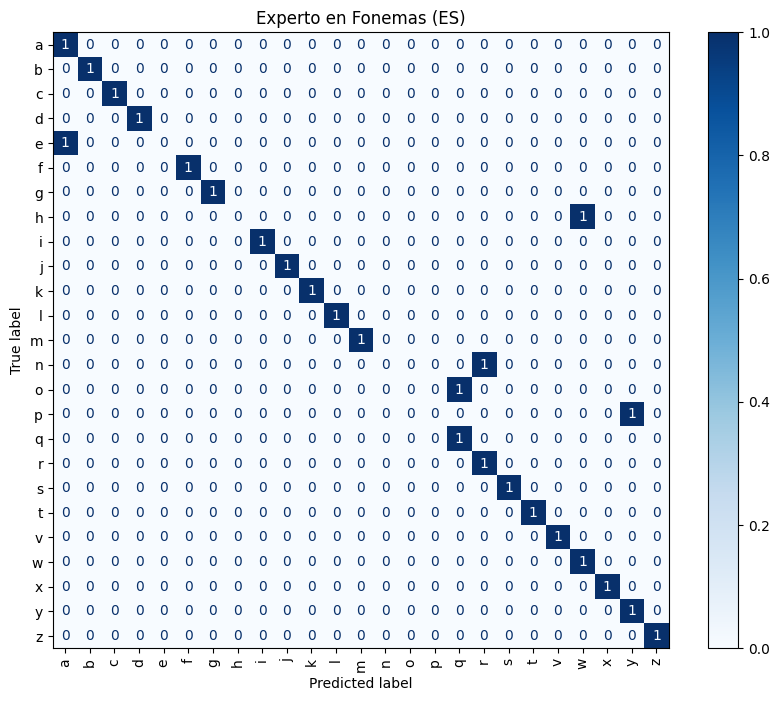

Modelo y mapeo para 'es' guardados en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/es_phoneme_expert.pth
--- Evaluando Experto en Fonemas para: EN ---


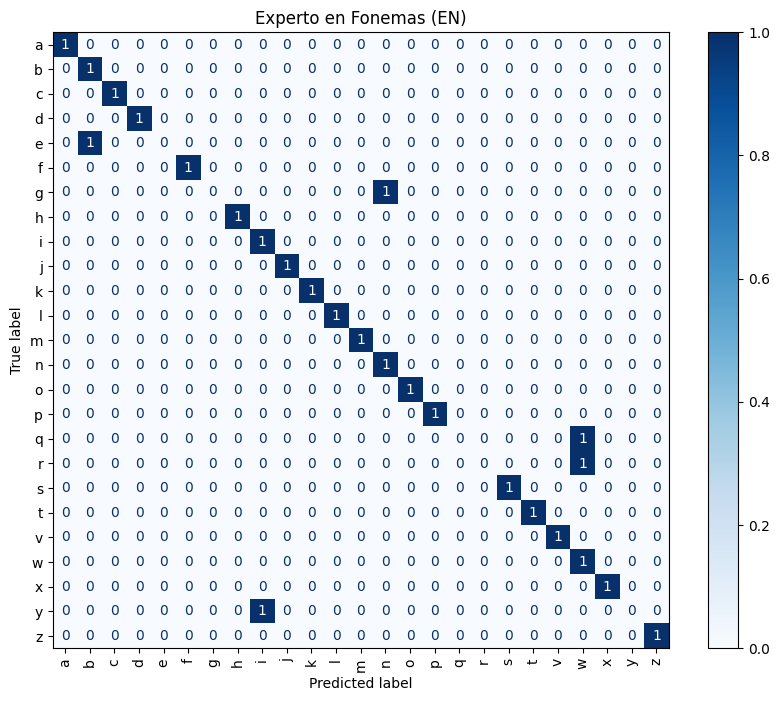

Modelo y mapeo para 'en' guardados en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/en_phoneme_expert.pth


In [12]:
# ===================================================================
# Celda 6: Visualización y Guardado - Experto en Fonemas
# ===================================================================
for lang, res in results_phonemes.items():
    print(f"--- Evaluando Experto en Fonemas para: {lang.upper()} ---")
    model = res['model']; dataset = res['dataset']
    full_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_sequential)
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for seqs, lengths, labels in full_loader:
            outputs = model(seqs.to(device), lengths)
            y_true.extend(labels.numpy()); y_pred.extend(outputs.argmax(1).cpu().numpy())
    fig, ax = plt.subplots(figsize=(10, 8))
    tick_labels = dataset.labels
    cm = confusion_matrix(y_true, y_pred, labels=range(len(tick_labels)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tick_labels)
    ax.set_title(f"Experto en Fonemas ({lang.upper()})")
    disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues'); plt.show()
    # --- ¡GUARDADO CORREGIDO! ---
    model_path = model_dir / f"{lang}_phoneme_expert.pth"
    torch.save({'model_state_dict': model.state_dict(), 'label_map': dataset.label_to_int}, model_path)
    print(f"Modelo y mapeo para '{lang}' guardados en: {model_path}")

# Parte 2: Entrenamiento del Experto en Palabras
Ahora repetimos el mismo proceso, pero para el conjunto de 50 palabras curadas. El objetivo es crear un clasificador que distinga entre palabras completas.

In [13]:
# ===================================================================
# Celda 7: Bucle de Entrenamiento - Experto en Palabras
# ===================================================================
results_words = {}
for lang in LANGUAGES:
    print(f"--- Entrenando Experto en Palabras para: {lang.upper()} ---")
    word_embedding_dir = word_embedding_dir_base / lang
    dict_path = dictionaries_dir / f"{lang}_words.txt"
    with open(dict_path, 'r', encoding='utf-8') as f: word_list = [line.strip() for line in f if line.strip()]
    temp_dataset = SequentialEmbeddingDataset(word_embedding_dir)
    files_to_keep = [str(word_embedding_dir / f"{word}.npy") for word in word_list]
    temp_dataset.embedding_files = [f for f in temp_dataset.embedding_files if f in files_to_keep]
    if not temp_dataset.embedding_files: print(f"No se encontraron embeddings. Saltando."); continue
    temp_dataset.labels = sorted([Path(f).stem for f in temp_dataset.embedding_files])
    temp_dataset.label_to_int = {label: i for i, label in enumerate(temp_dataset.labels)}
    temp_dataset.int_to_label = {i: label for label, i in temp_dataset.label_to_int.items()}
    full_dataset = temp_dataset; num_classes = len(full_dataset.labels)
    train_size = int((1.0 - VALIDATION_SPLIT) * len(full_dataset)); val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_sequential)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_sequential)
    model = SequentialClassifierLSTM(EMBED_DIM, num_classes, LSTM_HIDDEN_DIM, LSTM_N_LAYERS, LSTM_DROPOUT).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE); criterion = nn.CrossEntropyLoss()
    for epoch in tqdm(range(EPOCHS), desc=f"Entrenando Palabras {lang.upper()}", leave=False):
        model.train()
        for seqs, lengths, labels in train_loader:
            seqs, labels = seqs.to(device), labels.to(device)
            optimizer.zero_grad(); outputs = model(seqs, lengths)
            loss = criterion(outputs, labels); loss.backward(); optimizer.step()
    results_words[lang] = {'model': model, 'dataset': full_dataset}

--- Entrenando Experto en Palabras para: ES ---


Entrenando Palabras ES:   0%|          | 0/200 [00:00<?, ?it/s]

--- Entrenando Experto en Palabras para: EN ---


Entrenando Palabras EN:   0%|          | 0/200 [00:00<?, ?it/s]


--- Visualizando resultados del Experto en Palabras para: ES ---


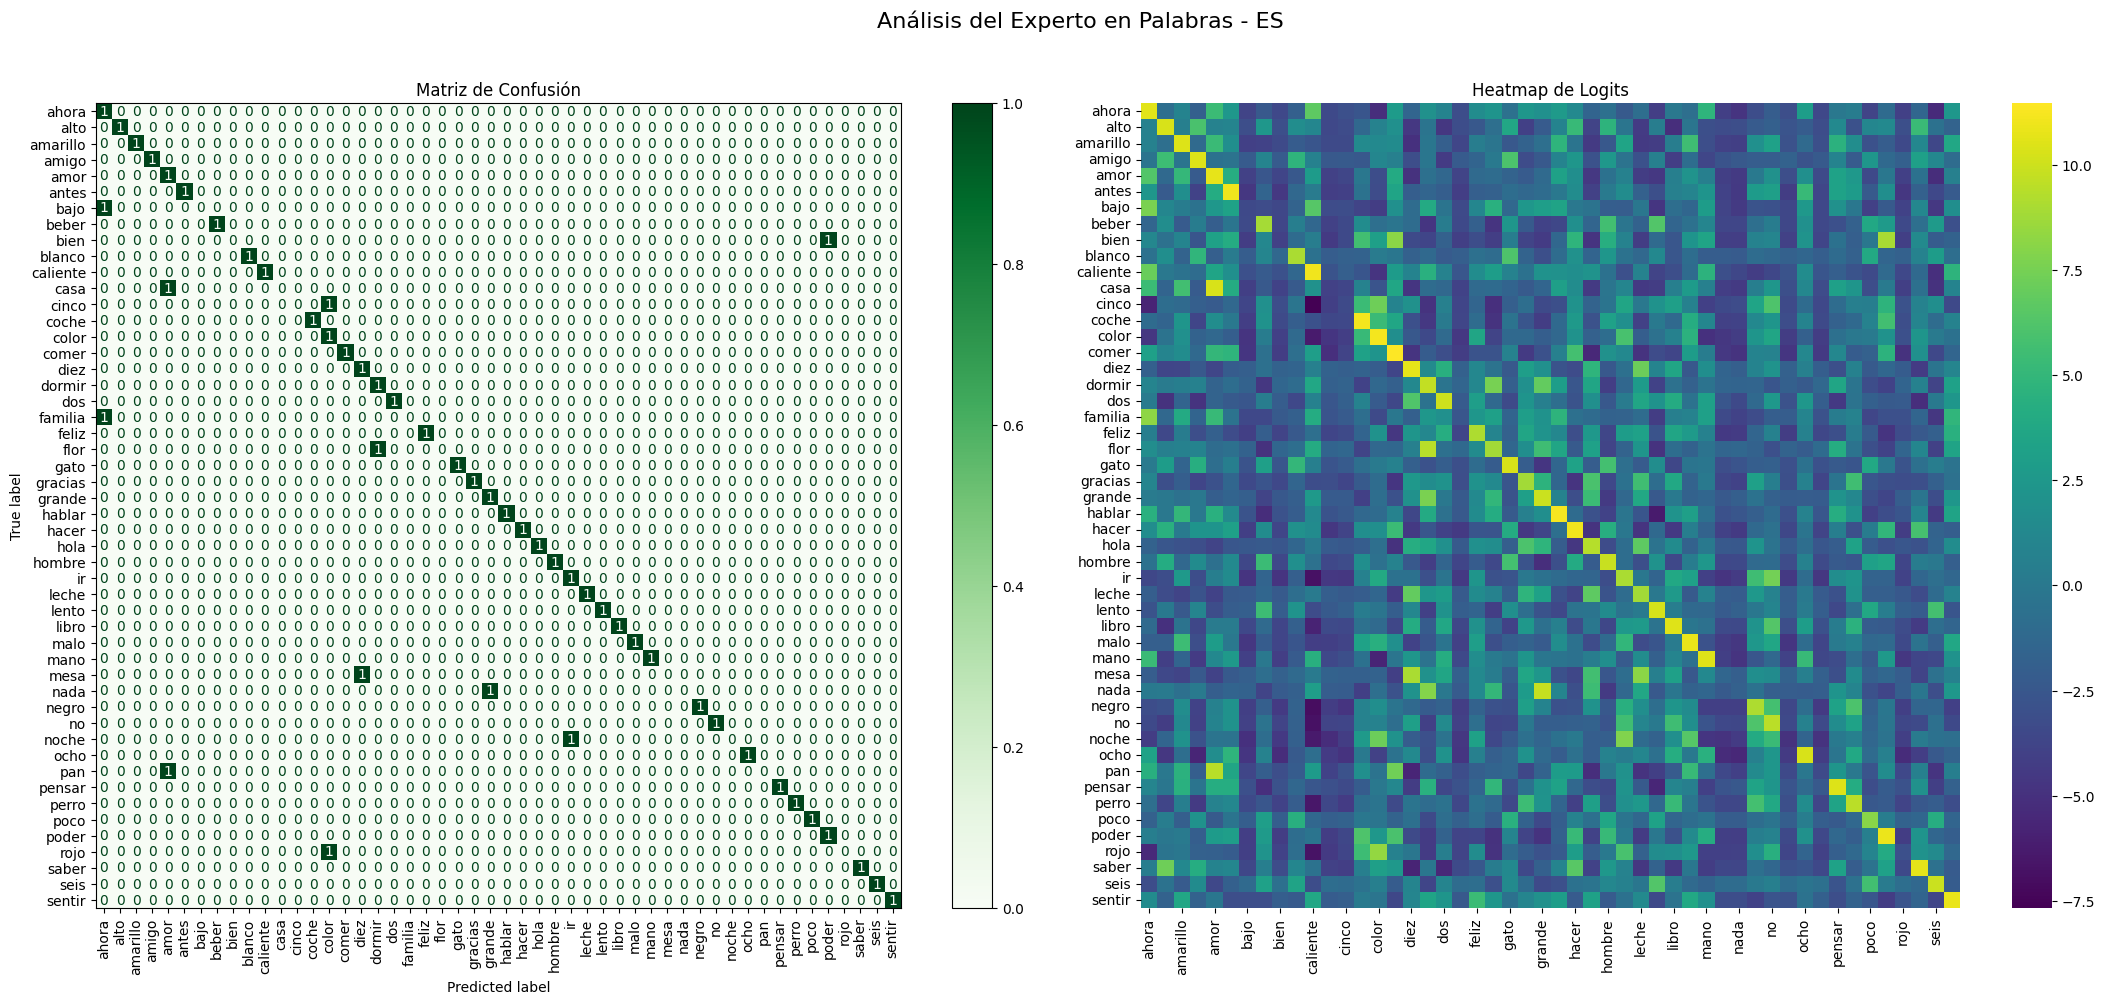


--- Visualizando resultados del Experto en Palabras para: EN ---


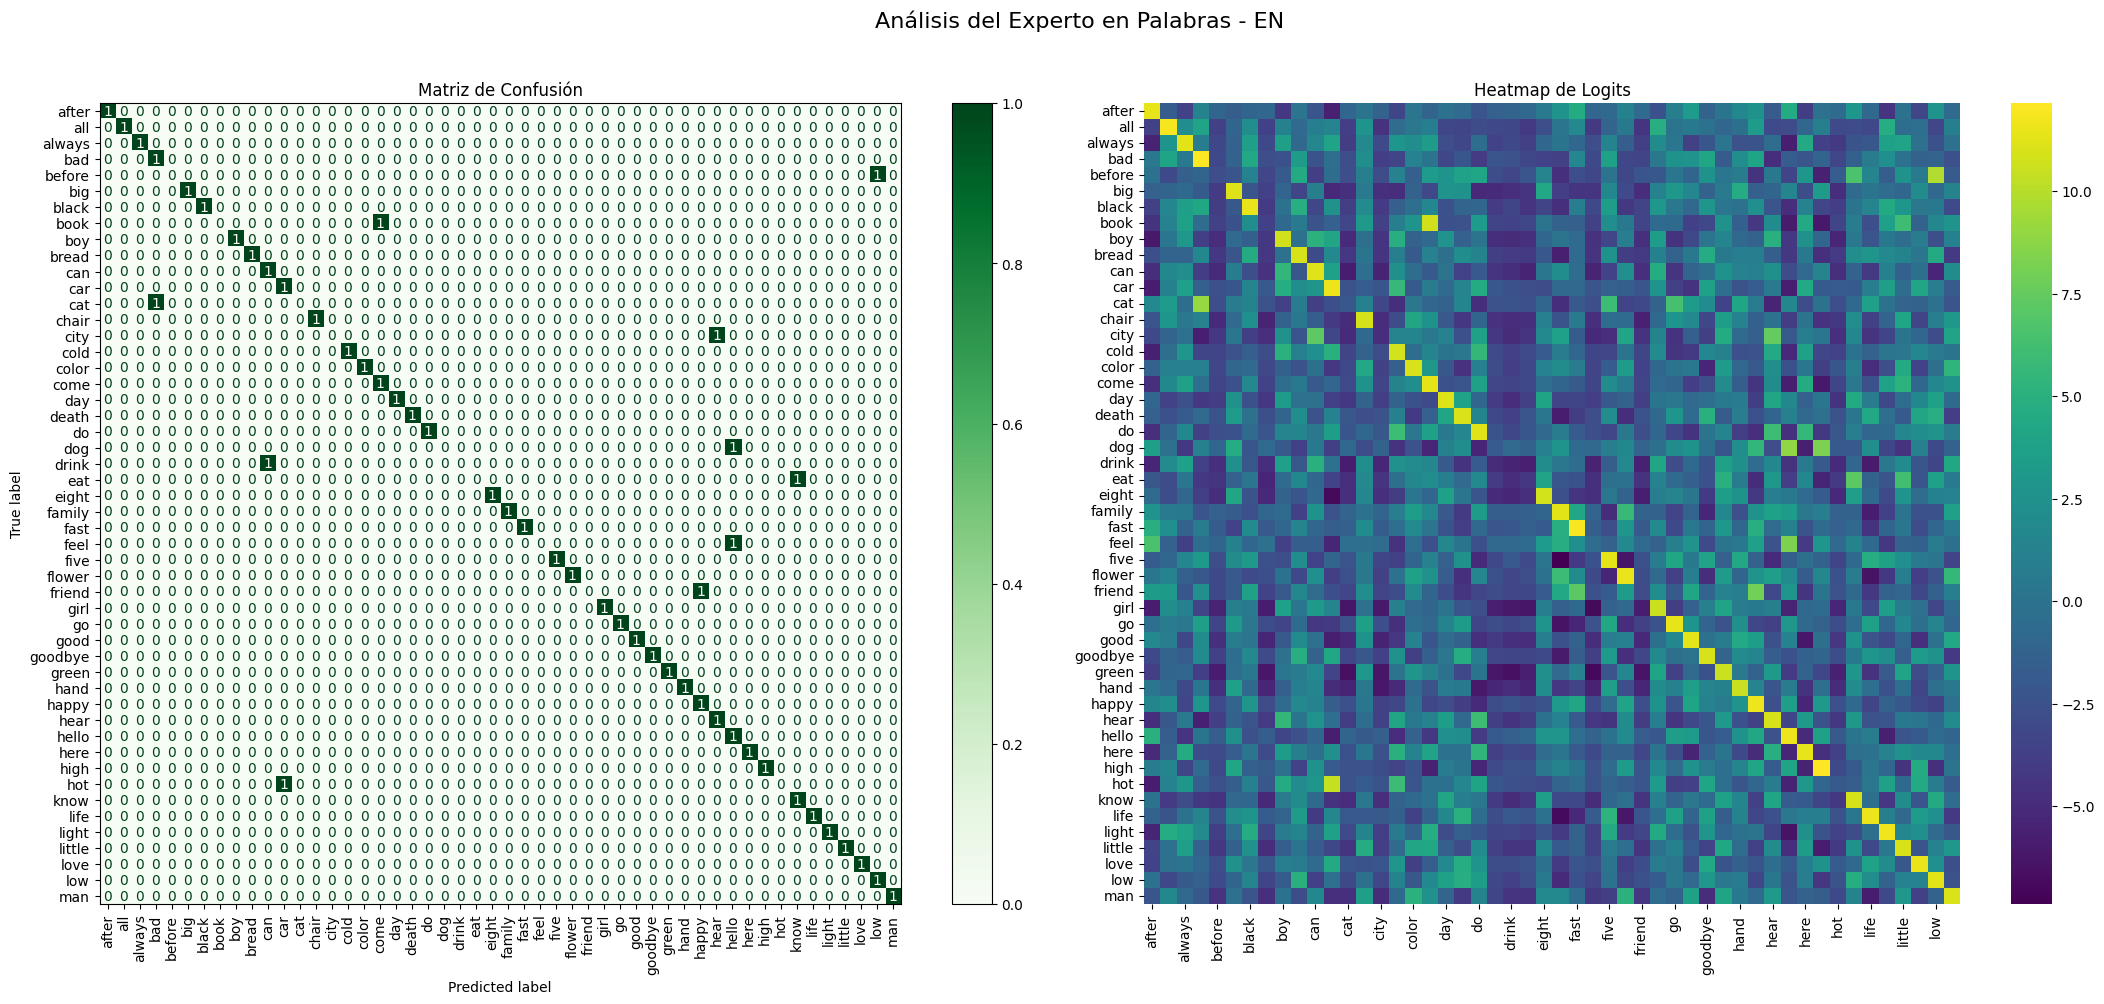

Modelo Experto en Palabras y mapeo para 'en' guardados en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/en_word_expert.pth


In [14]:
# ===================================================================
# Celda 10: Visualización de Resultados - Experto en Palabras
# ===================================================================
for lang, res in results_words.items():
    print(f"\n--- Visualizando resultados del Experto en Palabras para: {lang.upper()} ---")
    model = res['model']
    dataset = res['dataset']
    
    # --- Recolectar predicciones ---
    full_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_sequential)
    y_true, y_pred, logits_list = [], [], []
    model.eval()
    with torch.no_grad():
        for seqs, lengths, labels in full_loader:
            outputs = model(seqs.to(device), lengths)
            y_true.extend(labels.numpy())
            y_pred.extend(outputs.argmax(1).cpu().numpy())
            logits_list.append(outputs.cpu())
    
    # --- Matriz de Confusión y Logits ---
    fig, axes = plt.subplots(1, 2, figsize=(22, 10))
    fig.suptitle(f"Análisis del Experto en Palabras - {lang.upper()}", fontsize=16)
    
    tick_labels = list(dataset.int_to_label.values())
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tick_labels)
    axes[0].set_title("Matriz de Confusión")
    disp.plot(ax=axes[0], xticks_rotation='vertical', cmap='Greens')
    
    logits_df = pd.DataFrame(torch.cat(logits_list).numpy(), index=tick_labels, columns=tick_labels)
    axes[1].set_title("Heatmap de Logits")
    sns.heatmap(logits_df, ax=axes[1], cmap='viridis')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(figure_dir / f"{lang}_word_{MODEL_ARCHITECTURE}_evaluation.png")
    plt.show()

# --- Guardar Modelo y Mapeo de Etiquetas ---
model_path = model_dir / f"{lang}_word_expert.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'label_map': dataset.label_to_int
}, model_path)
print(f"Modelo Experto en Palabras y mapeo para '{lang}' guardados en: {model_path}")